# OptSum2016
## Collaborative filtering workshop

### 1. What is the data? Triplets & matrix "view" of the data
### 2. Intuition : predict taste using the tastes of similar users/items. KNN algorithm. Advantages & disadvantages
### 3. Introducing latent factor models (aka embeddings)
### 4. Model formulation and optimization
### 5. Training the model, performance and using embeddings

We know intuitively that items and people have attributes and characteristics. We might have some info, but sometimes we dont, and sometimes it is not descriptive enough.

Finding "hidden" attributes.

Formulate model
- embeddings
- biases

Go through code slowly

How will we optimize model
- Gradient descent
- Stochastic gradient
- Train-valid-test and early stopping
- patience

Go through SGD code slowly

Start the optimization
- Explain whats going on, training on k samples, evaluating on train/valid/test, saving parameters if necessary
- Variance because of stochastic

When optimization ends
- Learning curve, explain whats going on. Easy to learn in the beginning. overfitting/underfitting
- Save the parameters and try with high learning rate. What happens? Try with less/more factors?
- Suggestions for regularization (talk about L1 and L2 maybe)
- how to improve? model mixing, more information/implicit feedback, using attributes, more features, etc

How to evaluate?
rmse, vs baseline?
top k rankings

How to use the model?

We can look at the movies whose embedding is the most similar

In reality we must build a user profile and recommend movies that would be highest predicted ratings...


In [ ]:
# Introduce yourself, introduce the problem
# Netflix prize contest that produced some cool research on the subject

# http://conda.pydata.org/miniconda.html

# Lets load the data TODO Commit data & images
- If this cell works, the rest should work fine!

### The typical machine learning datasets are of the form:

$$
\huge{
\begin{array}{cc}
  input&target\\
  \mathbf{x}_1&y_1\\
  \mathbf{x}_2&y_2\\  
  \vdots & \vdots \\
  \mathbf{x}_N&y_N
\end{array}
}
$$

### , a set of input vectors ($\mathbf{x}_i$) and their associated targets ($y_i$), that we would like to predict.
### Here it is easy to use standard algorithms like linear regression.

### Our dataset can be better viewed as:
$$
\huge{
\begin{array}{ccc}
  user&item&rating\\
  u_1&v_1&r(u_1, v_1)\\
  \vdots & \vdots \\
  u_N&v_N&r(u_N, v_N)
\end{array}
}
$$

### , which is a set of triplets of users, items and ratings which tell us what rating users gave to certain items. These items can be different for all users, so we never had the "full" picture.
### You can visualize this problem with :

<img src="notebook_images/rating_matrix1.png" height="500" width="500">

### Alot of ratings are actually missing from this matrix. They are zero, they are simply missing.

### Lets load our experiment dataset.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)
%matplotlib inline
plt.style.use('ggplot')
# data = pd.read_csv('ml-20m/ratings_smaller.csv', index_col=0)
# movies = pd.read_csv('ml-20m/movies_smaller.csv')

data = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
movies = movies.set_index('movieId')[['title', 'genres']]

In [66]:
# How many users?
print data.userId.nunique(), 'users'

# How many movies?
print data.movieId.nunique(), 'movies'

# How possible ratings?
print data.userId.nunique() * data.movieId.nunique(), 'possible ratings'

# How many do we have?
print len(data), 'ratings'
print 100 * (float(len(data)) / (data.userId.nunique() * data.movieId.nunique())), '% of possible ratings'

# Less than 1%!

668 users
10325 movies
6897100 possible ratings
105339 ratings
1.52729408012 % of possible ratings


### MovieLens small dataset.
### We have:
- ### 700 Users
- ### 10,000 Movies
- ### This means 7,000,000 possible ratings.
- ### We have 100,000 ratings, so about 1.5% of all possible ratings.

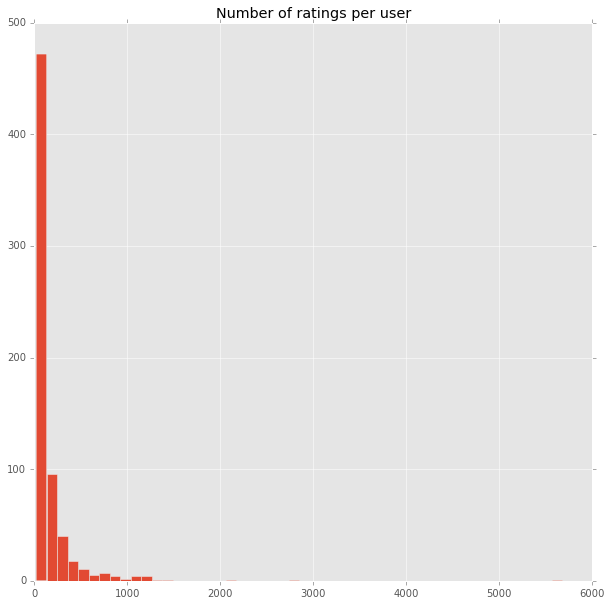

In [67]:
# Number of ratings per users
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.groupby('userId').apply(lambda x: len(x)).values, bins=50)
plt.title("Number of ratings per user")

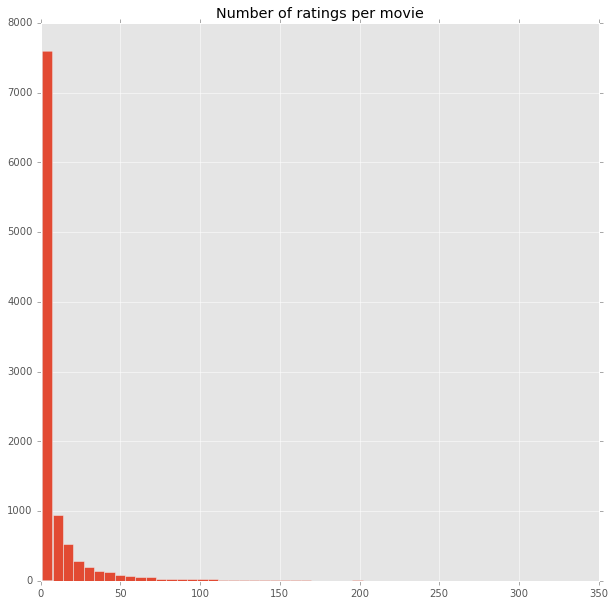

In [68]:
# Number of ratings per movie
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.groupby('movieId').apply(lambda x: len(x)).values, bins=50)
plt.title('Number of ratings per movie')

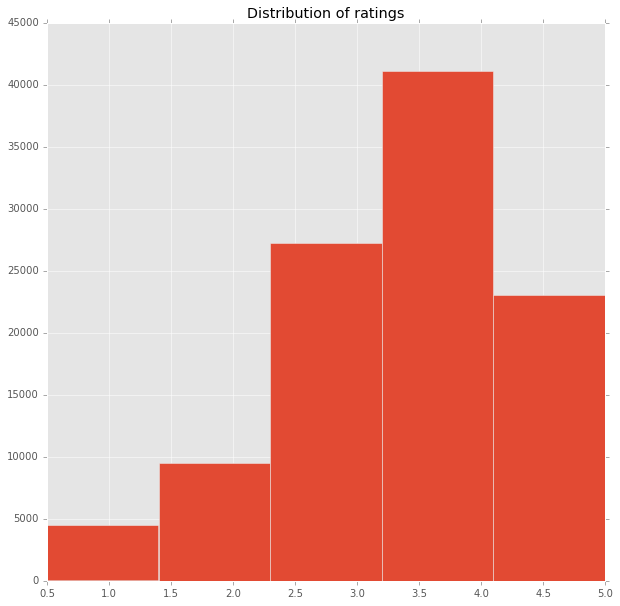

In [69]:
# Ratings distribution
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.rating.values, bins=5)
plt.title("Distribution of ratings")

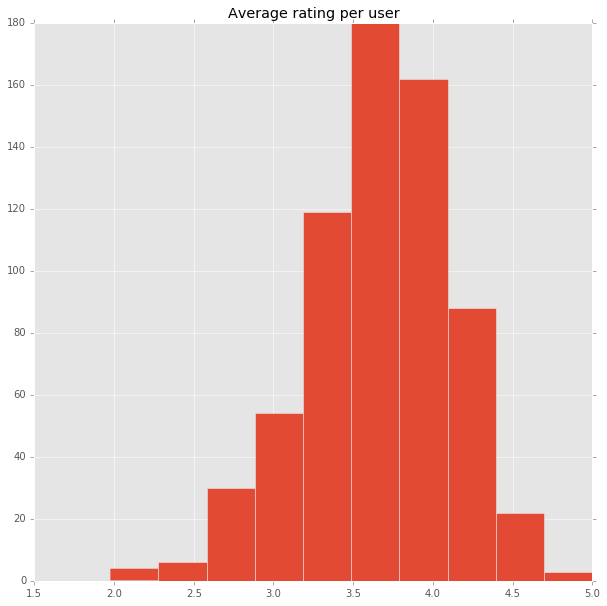

In [70]:
# Average rating per user
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.groupby('userId').rating.mean().values, bins=10)
plt.title("Average rating per user")

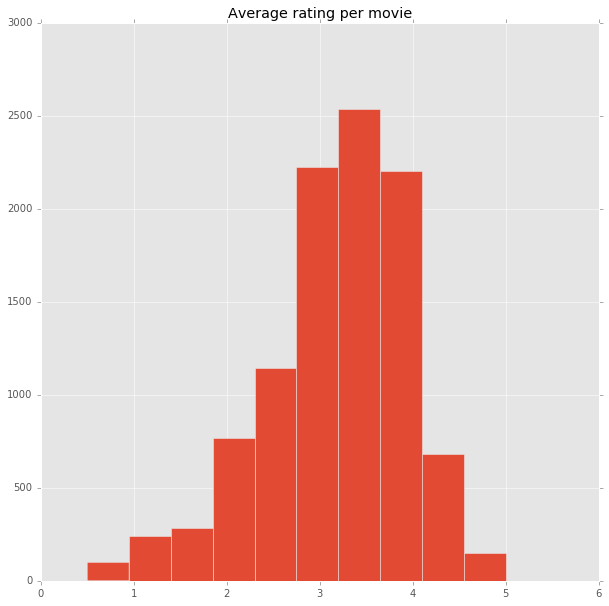

In [71]:
# Average rating per movie
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.groupby('movieId').rating.mean().values, bins=10)
plt.title('Average rating per movie')

In [72]:
# Top Movies
average_movie_rating = data.groupby('movieId').mean()
top_movies = average_movie_rating.sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[top_movies.index.values], 
           average_movie_rating.loc[top_movies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
465,Heaven & Earth (1993),Action|Drama|War,5
111387,Palo Alto (2013),Drama,5
1757,Fallen Angels (Duo luo tian shi) (1995),Drama|Romance,5
5003,"Nine Lives of Fritz the Cat, The (1974)",Animation,5
5007,Topkapi (1964),Adventure|Comedy|Thriller,5
5037,"Long Gray Line, The (1955)",Drama,5
5042,Forbidden Zone (1980),Musical|Sci-Fi,5
91007,I Want to Be a Soldier (2011),Drama,5
5056,"Enigma of Kaspar Hauser, The (a.k.a. Mystery o...",Crime|Drama,5


### Do you know any of those movies? I dont either...

In [73]:
# Robust Top Movies - Lets weight the average rating by the square root of number of ratings
top_movies = data.groupby('movieId').apply(lambda x:len(x)**0.5 * x.mean()).sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[top_movies.index.values], 
           average_movie_rating.loc[top_movies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.454545
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.194828
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.188645
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.264368
527,Schindler's List (1993),Drama|War,4.296371
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.328947
110,Braveheart (1995),Action|Drama|War,4.108871


In [74]:
controversial_movies = data.groupby('movieId').apply(lambda x:len(x)**0.25 * x.std()).sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[controversial_movies.index.values], 
           average_movie_rating.loc[controversial_movies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
344,Ace Ventura: Pet Detective (1994),Comedy,2.849711
231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,3.003356
1721,Titanic (1997),Drama|Romance,3.356209
1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,3.865672
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.659864
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
94439,Jumping the Broom (2011),Comedy,2.750000
60291,Gonzo: The Life and Work of Dr. Hunter S. Thom...,Documentary,2.750000


### We would like to produce estimates $\tilde{r}$ for all the missing ratings

<img src="notebook_images/rating_matrix2.png" height="500" width="500">

### Collaborative filtering is trying to complete the user-item rating matrix by sharing information across rows (users) and columns (items)
### Some ideas :

________________________________________________________________________________________________________________________________


### <center><i>Predict with the average rating of the available ratings for each item.</i></center>

### Actually a good solution in terms of simplicity vs. efficiency, but everyone gets the same predictions. What about movies with few ratings? Also not very personalized...

________________________________________________________________________________________________________________________________


### <center><i>Use the attributes of each item and build a model for each user using these attributes. This is known as content filtering.</i></center>

### Can work well, but sometimes the attributes are not very good (how can we know the difference between a good action movie and a bad one?). Also need thousands and thousands of classifiers, and information is not shared across users...
### Lets suppose we dont even have attributes.

________________________________________________________________________________________________________________________________


### <center><i>Predict using the average rating of the most similar movies of users (in terms of ratings)</i></center>

### Known as k-Nearest-Neighbours, a standard machine learning algorithm. This can work well, but requires some engineering to perform well and to scale well (as we need to query or precompute alot of information).


________________________________________________________________________________________________________________________________


### <center><i>Discover hidden attributes of the items and each user's preference for these attributes.</i></center>

### This is known as learning "embeddings" for users and items.

### Imagine that each item has a set of hidden attributes, and users have preferences for each of these attributes. The estimated rating could be the linear combination of the attributes and preferences (dot product).

<img src="notebook_images/rating_matrix3.png" height="500" width="500">

### This is like decomposing the matrix...

<img src="notebook_images/factorization.svg" height="700" width="700">

### How will we find the "hidden" attributes (embeddings) if they are... hidden ?

### We will formulate a mathematical model and apply numerical optimization to find the embeddings of items and users.

## <center> <font color="red">Warning!</font> Math ahead...</center>

### We want our model (function f) to minimize a given error measure between predictions and actual values.

## $$ \tilde{r} = f(u, i) $$

### Most basic error measure is the mean squared error :

## $$ \mathscr{E} = \frac{1}{N} \sum_{k=1...N} (\tilde{r}_k - r_k)  $$

### Our embeddings for users and items are written as:

### embedding for user u : 
## $$ p_u $$
### embedding for item i : 
## $$ q_i $$

### And our complicated model will be...

## $$ f(u,i)= q_i^{T} p_u  $$

### Perhaps we can do a little bit better with an even simpler modelling trick: some items are just bad, and some people are always positive. 
### We can model this by simply having a bias term for users and items, along with a main bias term for all ratings.
### This allows embeddings to encode the actual attributes of items and users instead of their bias.

### We will have a main bias:

## $$ b $$

### User bias for user u:

## $$ b_u $$

### And item bias for item i:

## $$ b_i $$


### Our final model will simply be the sum of all these terms.

## $$ f(u,i) = b + b_u + b_i + q_i^{T} p_u $$

### <center><font color="red">Still More Math...</font></center>

### We are not quite done yet...

### How do we find biases and embeddings for thousands of users and items?

### There are many numerical optimization algorithms. Lets use one that simple and efficient, gradient descent.

### Given our dataset, we can iteratively move the parameters in the appropriate direction to improve the mean squared error, until we are tired of waiting, or until performance does not improve anymore.

### This simply means moving in the direction of the gradient of the error with regards to the model parameters (usually called $ \theta $),  denoted by:
## $$ \frac{\delta \mathscr{L}}{\delta \theta} $$
### where
## $$ \theta = \{b, b_u, b_i, q_i, p_u\} $$
### for all users $u$ and items $i$.

### The "gradient descent" iteration is:
## $$ \theta \leftarrow \theta + \alpha \frac{\delta \mathscr{L}}{\delta \theta} $$
### Where $\alpha$ controls how big the gradient steps are. We call this the learning rate.

#### We could do this on the whole dataset at every iteration, adding the gradients together before updating. This is the standard gradient algorithm (compute the gradient on the whole training set and then update the parameters).
#### However we can speed this up alot by using one random training every iteration. Without going into too much detail, the gradient of a random training is, on average, the same as the gradient on the whole training set. This means we can go, in theory, thousands of times faster!

### <center><font color="red">Condensed information</font>:
- ### Loop over examples.
- ### Update model parameters to decrease the error.
- ### Continue until we cant improve anymore or we get bored.
</center>

### Gradient descent in one image:
<img src="notebook_images/sgd_optimal.png" height="600" width="600">

# <center><font color="blue">The Model</font></center>

## Now we are ready to train the model!

### Split the data into training and testing sets.

In [49]:
ratings = data[['userId', 'movieId', 'rating']].values

# Shuffle training examples for fair testing and evaluation
np.random.shuffle(ratings)

n_users, n_items, _ = ratings.max(axis=0) + 1

n = len(ratings)
split_ratios = [0, 0.7, 0.85, 1]
train_ratings, valid_ratings, test_ratings = [ratings[int(n*lo):int(n*up)] for (lo, up) in zip(split_ratios[:-1], split_ratios[1:])]

### Code for the model object.
### Implements code for
- #### Initializing embeddings and biases
- #### Saving and loading parameters
- #### Predicting given user-item pairs
- #### Update the parameters to decrease the error

In [85]:
gradients = ["dL_db", "dL_dbu", "dL_dbv", "dL_dU", "dL_dV"]

class Model(object):
    def __init__(self, latent_factors_size, L2_bias=0, L2_emb=0):
        self.model_parameters = []
        self.gradients = []
        for (name, value) in self.initialize_parameters(latent_factors_size):
            setattr(self, name, value)
            self.gradients.append("dL_d%s" % name)
            self.model_parameters.append(name)
    
    # Used to save parameters during the optimization
    def save_parameters(self):
        return [(name, np.copy(getattr(self, name))) for name in self.model_parameters]
    
    # Used to reload the best parameters once the optimization is finished
    def load_parameters(self, parameters):
        for (name, value) in parameters:
            setattr(self, name, value)
    
    # Random embedding generation from normal distribution, given a size and variance
    def initialize_parameters(self, latent_factors_size=100, std=0.05):
        U = np.random.normal(0., std, size=(n_users + 1, latent_factors_size))
        V = np.random.normal(0., std, size=(n_items + 1, latent_factors_size))
        u = np.zeros(n_users + 1)
        v = np.zeros(n_items + 1)
        return zip(("b", "u", "v", "U", "V"), (0, u, v, U, V))
            
    # Compute the gradients of the biases and embeddings, given 
    def compute_gradient(self, user_ids, item_ids, ratings):
        predicted_ratings = self.predict(user_ids, item_ids)
        residual = ratings - predicted_ratings

        # biases
        dL_db = -2 * residual
        dL_dbu = -2 * residual
        dL_dbv = -2 * residual

        # embeddings
        eu = self.U[user_ids]
        ev = self.V[item_ids]

        dL_dU = -2 * residual * ev
        dL_dV = -2 * residual * eu

        # Regularization
        l2 = 0.1
        dl2eu_dU = l2 * 2*eu
        dl2ev_dV = l2 * 2*ev
        dl2bu_dbu = l2 * 2*self.u[user_ids]
        dl2bv_dbv = l2 * 2*self.v[item_ids]
        
        dL_dbu = dL_dbu + dl2bu_dbu
        dL_dbv = dL_dbv + dl2bv_dbv
        dL_dU = dL_dU + dl2eu_dU
        dL_dV = dL_dV + dl2ev_dV
        
        return dict([(g, eval(g)) for g in gradients])
    
    # Sum of the biases and dot product of the embeddings
    def predict(self, user_ids, item_ids):
        user_ids = user_ids.astype('int')
        item_ids = item_ids.astype('int')
        return sum([self.b, 
                    self.u[user_ids], 
                    self.v[item_ids], 
                    (self.U[user_ids] * self.V[item_ids]).sum(axis=-1)])
    
    # Perform a gradient descent step
    def update_parameters(self, user, item, rating, learning_rate = 0.005):
        gradients = self.compute_gradient(user, item, rating)
        self.b = self.b - learning_rate * gradients['dL_db']
        self.u[user] = self.u[user] - learning_rate * gradients['dL_dbu']
        self.v[item] = self.v[item] - learning_rate * gradients['dL_dbv']
        self.U[user] = self.U[user] - learning_rate * gradients['dL_dU']
        self.V[item] = self.V[item] - learning_rate * gradients['dL_dV']

#### Some useful utilitary functions

In [86]:
# Generate a random number 
def sample_random_training_index():
    return np.random.randint(0, len(train_ratings))

# Compute root mean squared error between x and y
def compute_rmse(x, y):
    return ((x - y)**2).mean()**0.5

# utilitary functions for getting the train/valid/test
def get_rmse(ratings):
    return compute_rmse(model.predict(*ratings.T[:2]), ratings.T[2])

def get_trainset_rmse():
    return get_rmse(train_ratings)

def get_validset_rmse():
    return get_rmse(valid_ratings)

def get_testset_rmse():
    return get_rmse(test_ratings)

#### Initialization of the model and optimization

In [91]:
model = Model(latent_factors_size=100)
model.b = train_ratings[:,2].mean()

sgd_iteration_count = 0
best_validation_rmse = 9999
patience = 0
update_frequency = 10000

train_errors = []
valid_errors = []
test_errors = []

best_parameters = None

# model size = 100
# learning rate = 0.005
# l2 = 0.1

#### The gradient descent optimization
#### Additional notes concerning optimization:
<ul>
  <li>We will measure performance on the validation set. Optimization will stop when we no longer improve on the validation, after a certain number of iterations (patience).</li>
  <li>We will save the error on the training, validation and test set every 10000 iterations.</li>
  <li>Whenever we see the best validation error up to now, we will save the model parameters.</li>
</ul>

In [92]:
start_time = time.time()

while True:
    try:
        if sgd_iteration_count%update_frequency == 0:
            train_set_rmse = get_trainset_rmse()
            valid_set_rmse = get_validset_rmse()
            test_set_rmse = get_testset_rmse()
            
            train_errors.append(train_set_rmse)
            valid_errors.append(valid_set_rmse)
            test_errors.append(test_set_rmse)
            
            print 'Iteration:      ', sgd_iteration_count
            print 'Validation RMSE:', valid_set_rmse

            if valid_set_rmse < best_validation_rmse:
                print 'Test RMSE      :', test_set_rmse
                print 'Best validation error up to now !'
                patience = 0
                best_validation_rmse = valid_set_rmse
                best_parameters = model.save_parameters()
            else:
                patience += 1
                if patience >= 20:
                    print 'Exceed patience for optimization, stopping!'
                    break
            print
        training_idx = sample_random_training_index()
        user, item, rating = train_ratings[training_idx]
        model.update_parameters(user, item, rating)
        sgd_iteration_count += 1
    except KeyboardInterrupt:
        print 'Stopped Optimization'
        print 'Current valid set performance=%s' % compute_rmse(model.predict(*valid_ratings.T[:2]), valid_ratings[:,2])
        print 'Current test set performance=%s' % compute_rmse(model.predict(*test_ratings.T[:2]), test_ratings[:,2])
        break
        
model.load_parameters(best_parameters)
stop_time = time.time()

print 'Optimization time : ', (stop_time - start_time)/60., 'minutes'

Iteration:       0
Validation RMSE: 1.03996128073
Test RMSE      : 1.04139743303
Best validation error up to now !

Iteration:       10000
Validation RMSE: 0.985720374504
Test RMSE      : 0.985962478004
Best validation error up to now !

Iteration:       20000
Validation RMSE: 0.953858586001
Test RMSE      : 0.956258426291
Best validation error up to now !

Iteration:       30000
Validation RMSE: 0.938547628364
Test RMSE      : 0.94195127961
Best validation error up to now !

Iteration:       40000
Validation RMSE: 0.930229037133
Test RMSE      : 0.934957635723
Best validation error up to now !

Iteration:       50000
Validation RMSE: 0.923503582418
Test RMSE      : 0.927950869008
Best validation error up to now !

Iteration:       60000
Validation RMSE: 0.923592921526

Iteration:       70000
Validation RMSE: 0.913709673343
Test RMSE      : 0.916723690355
Best validation error up to now !

Iteration:       80000
Validation RMSE: 0.90967771792
Test RMSE      : 0.912970916975
Best valida

### How much should be wait? 
### How good is the model? 
### Is the optimization ok?

### Lets first try to answer some of these questions by looking at the so-called learning curve

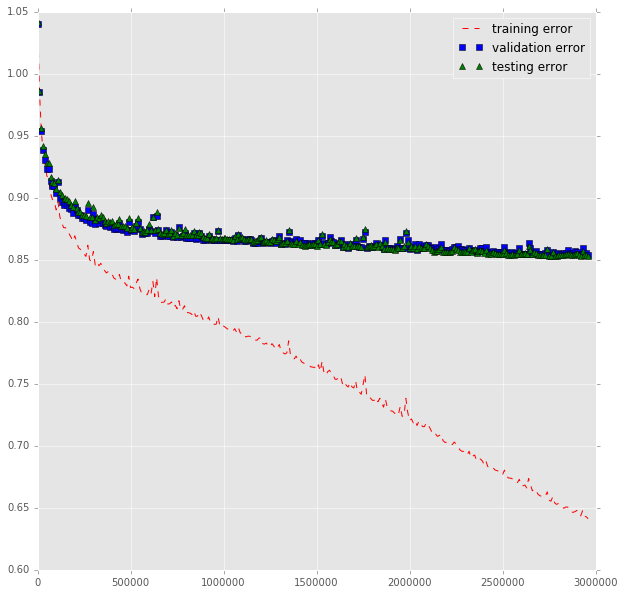

In [102]:
x = update_frequency * np.arange(len(train_errors))
fig = plt.figure(num=None, figsize=(10, 10), dpi=500)
plt.plot(x, train_errors, 'r--', x, valid_errors, 'bs', x, test_errors, 'g^')
plt.legend(['training error', 'validation error', 'testing error'])

### We can see that most of the learning is done early during the optimization. In general, better results can be achieved by waiting.

### Training error will always be lower than validation and testing error. When the difference is too great we call this "overfitting".

- #### Bigger embedding size can lead to more overfitting. 
- #### Smaller size will overfit less, but may perform more poorly on the test set. The best is somewhere in between...

### There are also many other things we can do to improve the performance and "generalization":

- #### Regularization : forcing embeddings to be smaller, so that its harder to overfit. Different coefficients for user/item bias and embedding.
- #### Learning rate reduction : reducing the learning rate in the later stages of training can help.
- #### Implicit feedback : use who rated what information, without the rating value
- #### Tuning all the hyperparameters of the model (learning rate, embedding size, regularization, ...)
- #### And many many more...


# <center><font color="blue">Evaluation!</font></center>

### Now that we have a model, how do we evaluate it, and more importantly, how do we use it?

In [103]:
test_predictions = model.predict(*test_ratings.T[:2])
test_df = pd.DataFrame({'userId': test_ratings[:, 0],
                        'movieId': test_ratings[:, 1],
                        'rating': test_ratings[:, 2],
                        'prediction': test_predictions})
test_df.head()

,movieId,prediction,rating,userId
0,63481,3.162219,3.5,475
1,1259,4.523523,4.5,519
2,593,4.257541,5.0,326
3,54775,2.286901,1.5,668
4,3752,3.059051,1.0,468


## Standard error metrics for global performance of test set

In [104]:
print 'Root Mean Squared Error\t\t', ((test_df.rating - test_df.prediction)**2).mean()**0.5
print 'Mean Absolute Error\t\t', (test_df.rating - test_df.prediction).abs().mean()
print 'Mean Absolute Percentile Error\t', 100*((test_df.rating - test_df.prediction).abs() / test_df.rating).mean(), '%'

Root Mean Squared Error		0.853124618471
Mean Absolute Error		0.659088465622
Mean Absolute Percentile Error	28.352689164 %


## Top-k metrics - precision @ top k across users

In [105]:
best_predicted_rating_per_user = test_df.groupby('userId').apply(lambda x: x.sort_values('prediction', ascending=False).head(1).rating)

In [106]:
best_rating_per_user = test_df.groupby('userId').apply(lambda x: x.sort_values('rating', ascending=False).head(1).rating)

In [107]:
mean_rating_per_user = test_df.groupby('userId').rating.mean()

In [108]:
# Best rating per user - Best possible performance
print 'Best rating per user\t\t', best_rating_per_user.mean()
# Best predicted rating per user
print 'Best predicted rating per user\t', best_predicted_rating_per_user.mean()
# Random or average performance - Used as baseline
print 'Best mean rating per user\t', mean_rating_per_user.mean()

Best rating per user		4.7263868066
Best predicted rating per user	4.14992503748
Best mean rating per user	3.6592404732


In [109]:
# Precision @ 1


# But the most important is... <font color="red">business validation</font>!
- ## Looking at how the model will behave in practice

## One way of looking at embeddings is comparing them together

In [110]:
movies_embeddings = dict([(i, model.V[i]) for i in movies.index.values])

def compute_cosine_similarity(movieId):
    movie_embedding = movies_embeddings[movieId]
    movie_embedding_norm = (movie_embedding**2).sum()**0.5
    similarity = dict([(movie, ((movie_embedding*emb).sum()) / (((emb**2).sum()**0.5) * movie_embedding_norm))
                              for (movie, emb) in movies_embeddings.iteritems()])
    return  similarity

def compute_euclidian_similarity(movieId):
    movie_embedding = movies_embeddings[movieId]
    similarity = dict([(movie, -((movie_embedding-emb)**2).sum()**0.5)
                              for (movie, emb) in movies_embeddings.iteritems()])
    return  similarity

In [111]:
movies[movies.title.str.startswith('Lord')]

,title,genres
movieId,,
177,Lord of Illusions (1995),Horror
2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
3461,Lord of the Flies (1963),Adventure|Drama|Thriller
3590,"Lords of Flatbush, The (1974)",Comedy|Drama
4951,Lord of the Flies (1990),Adventure|Drama|Thriller
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
8852,Lord Jim (1965),Adventure|Drama


In [116]:
movieId = 5952 # lord of the rings
# movieId = 1 # toy story


sorted_movies = sorted(compute_cosine_similarity(movieId).items(), key = lambda x:x[1])
# sorted_movies = sorted(compute_euclidian_similarity(movieId).items(), key = lambda x:x[1])

print 'Closest'
for i in range(1, 16):
    id, sim = sorted_movies[-i]
    print i, movies.loc[id].title, '\t', movies.loc[id].genres, sim
    print

print 'Farthest'
for i in range(15,-1,-1):
    id, sim = sorted_movies[i]
    print i, movies.loc[id].title
    print '\t', movies.loc[id].genres, sim
    print

Closest
1 Lord of the Rings: The Two Towers, The (2002) 	Adventure|Fantasy 1.0

2 Lord of the Rings: The Return of the King, The (2003) 	Action|Adventure|Drama|Fantasy 0.817647579159

3 Lord of the Rings: The Fellowship of the Ring, The (2001) 	Adventure|Fantasy 0.780496951703

4 Ocean's Eleven (2001) 	Crime|Thriller 0.566011315072

5 Harry Potter and the Chamber of Secrets (2002) 	Adventure|Fantasy 0.530486100425

6 Spider-Man 2 (2004) 	Action|Adventure|Sci-Fi|IMAX 0.527249472709

7 Pirates of the Caribbean: The Curse of the Black Pearl (2003) 	Action|Adventure|Comedy|Fantasy 0.515183699374

8 Spider-Man (2002) 	Action|Adventure|Sci-Fi|Thriller 0.514615689586

9 Gladiator (2000) 	Action|Adventure|Drama 0.506172616995

10 X2: X-Men United (2003) 	Action|Adventure|Sci-Fi|Thriller 0.499146114828

11 Dark Knight, The (2008) 	Action|Crime|Drama|IMAX 0.464691170356

12 Passion of the Christ, The (2004) 	Drama 0.457672871696

13 Harry Potter and the Prisoner of Azkaban (2004) 	Adventure|Fant

# Although this is one way, the real way would be to create user profiles yourself, and see what the system can recommend, maybe watch it yourself :)

# Useful links and sources
- Main reference paper : https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf
- Netflix Prize solutions & papers published with the Netflix dataset 
- Collaborative Filtering Datasets : https://gist.github.com/entaroadun/1653794

# Thank you!

# Questions?

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)
data = pd.read_csv('ml-20m/ratings.csv')
movies = pd.read_csv('ml-20m/movies.csv')

top_rated_movies = data.groupby('movieId').rating.count().sort_values(ascending=False)
top_rating_users = data.groupby('userId').rating.count().sort_values(ascending=False)

top_rated_movies = top_rated_movies[top_rated_movies>500].index.values
top_rating_users = top_rating_users[top_rating_users>50].index.values

smaller_data = data[(data.movieId.isin(top_rated_movies)) & (data.userId.isin(top_rating_users))]
smaller_data.shape

# sample smaller dataset
smaller_data = smaller_data.reindex(np.random.permutation(smaller_data.index)).head(1500000)

movie_id_remapping = {}
user_id_remapping = {}
    
def remap_movie_id(i):
    if not i in movie_id_remapping:
        movie_id_remapping[i] = len(movie_id_remapping)
    return movie_id_remapping[i]

def remap_user_id(i):
    if not i in user_id_remapping:
        user_id_remapping[i] = len(user_id_remapping)
    return user_id_remapping[i]

smaller_data.movieId = smaller_data.movieId.apply(remap_movie_id)
smaller_data.userId = smaller_data.userId.apply(remap_user_id)

movies = movies[movies.movieId.isin(movie_id_remapping)]
movies.movieId = movies.movieId.apply(remap_movie_id)

smaller_data.to_csv('ml-20m/ratings_smaller.csv')
movies.to_csv('ml-20m/movies_smaller.csv')

# use sklearn?
import numpy as np
np.random.seed(123)
# One-liner just to load and parse the text file
ratings = np.array([[int(x) for x in r.strip().split('::')]
                    for r in open("ml-1m/ratings.dat").xreadlines()])[:,:-1]
# Shuffle training examples for fair testing and evaluation
np.random.shuffle(ratings)

n_users, n_items, _ = ratings.max(axis=0) + 1

n = len(ratings)
split_ratios = [0, 0.7, 0.85, 1]
train_ratings, valid_ratings, test_ratings = [ratings[int(n*lo):int(n*up)] for (lo, up) in zip(split_ratios[:-1], split_ratios[1:])]

In [ ]:
user_ratings = {}
item_ratings = {}
user_rated_items = {}
item_rating_users = {}

for u, i, r in train_ratings:
    if u not in user_ratings:
        user_ratings[u] = {}
    if i not in item_ratings:
        item_ratings[i] = {}
    user_ratings[u][i] = r
    item_ratings[i][u] = r
    
    if u not in user_rated_items:
        user_rated_items[u] = set()
    if i not in item_rating_users:
        item_rating_users[i] = set()
    user_rated_items[u].add(i)
    item_rating_users[i].add(u)

user, item, rating = valid_ratings[0]

# compute similarity of all other items for that item - itemwise because items are rated by alot of users

similarity = {}
for item_i in (set(item_rating_users.keys()) - set([item])):
    
    i_ratings = item_ratings[item_i]

    # Users that rated both "item" and "i"
    common_users = item_rating_users[item] & item_rating_users[item_i]
    
    # Compute similarity between user and each of the common users.
    current_user_ratings = user_ratings[user]
    
    import pdb; pdb.set_trace()
    
    print common_users